# Графовая сеть

## Импорт библиотек

In [38]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from typing import List, Tuple, Dict
from torchinfo import summary
from torch_geometric.utils import to_networkx, degree
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures

## Определение класса DatasetManager

In [39]:
class DatasetManager:
    def __init__(self, dataset_name: str = "Cora", root_dir: str = "data") -> None:
        """
        Загружает Planetoid-датасет и нормализует признаки.

        Параметры:
            dataset_name (str): Название датасета.
            root_dir (str): Путь к директории для хранения данных.
        """
        self.dataset = Planetoid(
            root=f"{root_dir}/{dataset_name}",
            name=dataset_name,
            transform=NormalizeFeatures(),
        )
        self.data: Data = self.dataset[0]

    def summary(self) -> None:
        """Выводит основную информацию о графе в формате таблицы."""
        d = self.data
        deg = degree(d.edge_index[0], d.num_nodes).cpu().numpy()

        metrics = {
            "Nodes": d.num_nodes,
            "Edges": d.num_edges,
            "Node features": d.num_node_features,
            "Classes": self.dataset.num_classes,
            "Train nodes": int(d.train_mask.sum()),
            "Validation nodes": int(d.val_mask.sum()),
            "Test nodes": int(d.test_mask.sum()),
            "Avg degree": float(deg.mean()),
            "Min degree": int(deg.min()),
            "Max degree": int(deg.max()),
        }

        df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
        df.index.name = "Metric"
        print("\033[92m" + "Метрики графа:" + "\033[0m")
        print(df.to_markdown())

    def label_summary(self) -> None:
        """Выводит распределение классов в графе и строит столбчатую диаграмму."""
        cora_label_names: Dict[int, str] = {
            0: "Case_Based",
            1: "Genetic_Algorithms",
            2: "Neural_Networks",
            3: "Probabilistic_Methods",
            4: "Reinforcement_Learning",
            5: "Rule_Learning",
            6: "Theory",
        }

        labels = self.data.y.cpu().numpy()
        counts = pd.Series(labels).value_counts().sort_index()

        df = pd.DataFrame(
            {
                "Label ID": counts.index,
                "Label Name": [cora_label_names[i] for i in counts.index],
                "Count": counts.values,
            }
        )

        print("\033[92m" + "Метки классов:" + "\033[0m")
        print(df.to_markdown(index=False))

        plt.figure(figsize=(8, 5))
        plt.bar(df["Label Name"], df["Count"], color="skyblue")
        plt.xticks(rotation=45, ha="right")
        plt.xlabel("Label Name")
        plt.ylabel("Number of Nodes")
        plt.title("Distribution of Classes in Cora Dataset")
        plt.tight_layout()
        plt.show()

    def show_sample_nodes(self, n: int = 10) -> None:
        """
        Показывает первые n вершин графа: метку и часть признаков.

        Параметры:
            n (int): Количество узлов для отображения.
        """
        d = self.data
        print("\033[92m" + f"Первые {min(n, d.num_nodes)} вершин графа:" + "\033[0m")
        for i in range(min(n, d.num_nodes)):
            feat = d.x[i].tolist()
            label = int(d.y[i])
            print(f"Node {i:4d} | label={label} | features={feat[:10]}...")

    def degree_stats(self, bins: int = 50) -> None:
        """
        Строит гистограмму распределения степеней вершин.

        Параметры:
            bins (int): Количество столбцов в гистограмме.
        """
        deg = degree(self.data.edge_index[0], self.data.num_nodes)
        plt.figure(figsize=(6, 4))
        plt.hist(deg.cpu().numpy(), bins=bins)
        plt.title("Degree Distribution")
        plt.xlabel("Degree")
        plt.ylabel("Count")
        plt.show()

    def plot_graph(self, n_nodes: int = 200) -> None:
        """
        Строит визуализацию подграфа первых n_nodes вершин.

        Параметры:
            n_nodes (int): Количество узлов для визуализации.
        """
        sub_data = self.data.subgraph(torch.arange(min(n_nodes, self.data.num_nodes)))
        G = to_networkx(sub_data, to_undirected=True)
        plt.figure(figsize=(6, 6))
        pos = nx.spring_layout(G, seed=42)
        nx.draw_networkx_nodes(G, pos, node_size=20)
        nx.draw_networkx_edges(G, pos, alpha=0.5)
        plt.title(f"Subgraph of first {n_nodes} nodes")
        plt.axis("off")
        plt.show()

## Определение класса TrainingManager

In [40]:
class TrainingManager:
    def __init__(
        self,
        model: torch.nn.Module,
        data: Data,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.Module,
        max_epochs: int = 200,
        patience: int = 20,
    ) -> None:
        """
        Инициализирует менеджер обучения для модели.

        Параметры:
            model (torch.nn.Module): Модель GNN.
            data (Data): Графовые данные.
            optimizer (torch.optim.Optimizer): Оптимизатор.
            criterion (torch.nn.Module): Функция потерь.
            max_epochs (int): Максимальное количество эпох обучения.
            patience (int): Число эпох без улучшения для ранней остановки.
        """
        self.model = model
        self.data = data
        self.opt = optimizer
        self.crit = criterion
        self.max_epochs = max_epochs
        self.patience = patience

        self.train_losses: List[float] = []
        self.train_accs: List[float] = []
        self.val_accs: List[float] = []
        self.test_accs: List[float] = []

    def train_epoch(self) -> float:
        """Выполняет одну эпоху обучения и возвращает loss."""
        self.model.train()
        self.opt.zero_grad()
        out = self.model(self.data.x, self.data.edge_index)
        loss = self.crit(out[self.data.train_mask], self.data.y[self.data.train_mask])
        loss.backward()
        self.opt.step()
        return loss.item()

    @torch.no_grad()
    def evaluate(self, mask: torch.Tensor) -> float:
        """Оценивает точность модели на заданной маске узлов."""
        self.model.eval()
        out = self.model(self.data.x, self.data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == self.data.y[mask]).sum().item()
        total = mask.sum().item()
        return correct / total

    def train(self) -> None:
        """Запускает процесс обучения модели с ранней остановкой."""
        best_val = 0
        patience_ctr = 0

        print("\033[92m" + "Обучение модели..." + "\033[0m")
        for epoch in range(1, self.max_epochs + 1):
            loss = self.train_epoch()
            train_acc = self.evaluate(self.data.train_mask)
            val_acc = self.evaluate(self.data.val_mask)
            test_acc = self.evaluate(self.data.test_mask)

            self.train_losses.append(loss)
            self.train_accs.append(train_acc)
            self.val_accs.append(val_acc)
            self.test_accs.append(test_acc)

            print(
                f"Epoch {epoch:03d} | Loss: {loss:.4f} "
                f"| Train: {train_acc:.4f} "
                f"| Val: {val_acc:.4f} "
                f"| Test: {test_acc:.4f}"
            )

            if val_acc > best_val:
                best_val = val_acc
                patience_ctr = 0
            else:
                patience_ctr += 1

            if patience_ctr >= self.patience:
                print(f"Early stopping at epoch {epoch}")
                break

    def plot_loss(self) -> None:
        """Строит график изменения loss от числа эпох."""
        plt.figure(figsize=(6, 4))
        plt.plot(self.train_losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self) -> None:
        """Строит график изменения accuracy для train, val и test."""
        plt.figure(figsize=(6, 4))
        plt.plot(self.train_accs, label="Train")
        plt.plot(self.val_accs, label="Val")
        plt.plot(self.test_accs, label="Test")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy over Epochs")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Определение класса GCN

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels: int) -> None:
        """Определяет двухслойную GCN-сеть."""
        super().__init__()
        self.conv1 = GCNConv(manager.data.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, manager.dataset.num_classes)
        self.dropout = 0.5

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """Прямое распространение модели."""
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Инициализация датасета

In [42]:
manager = DatasetManager(dataset_name="Cora", root_dir="data")

## Вывод информации о графе

In [43]:
manager.summary()

Метрики графа:
| Metric           |       Value |
|:-----------------|------------:|
| Nodes            |  2708       |
| Edges            | 10556       |
| Node features    |  1433       |
| Classes          |     7       |
| Train nodes      |   140       |
| Validation nodes |   500       |
| Test nodes       |  1000       |
| Avg degree       |     3.89808 |
| Min degree       |     1       |
| Max degree       |   168       |


## Распределение классов в графе

Метки классов:
|   Label ID | Label Name             |   Count |
|-----------:|:-----------------------|--------:|
|          0 | Case_Based             |     351 |
|          1 | Genetic_Algorithms     |     217 |
|          2 | Neural_Networks        |     418 |
|          3 | Probabilistic_Methods  |     818 |
|          4 | Reinforcement_Learning |     426 |
|          5 | Rule_Learning          |     298 |
|          6 | Theory                 |     180 |


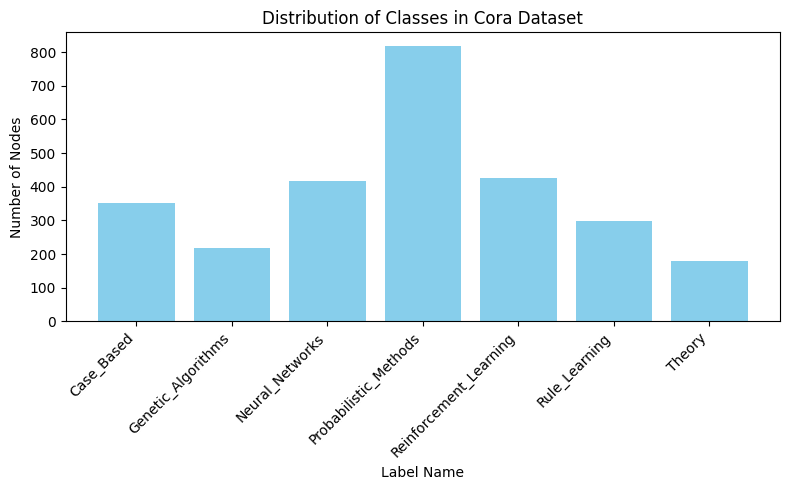

In [44]:
manager.label_summary()

## Обзор первых N вершин графа

In [45]:
manager.show_sample_nodes(10)

Первые 10 вершин графа:
Node    0 | label=3 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    1 | label=4 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    2 | label=4 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    3 | label=0 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    4 | label=3 | features=[0.0, 0.0, 0.0, 0.0555555559694767, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    5 | label=2 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    6 | label=0 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    7 | label=3 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    8 | label=3 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...
Node    9 | label=2 | features=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...


## Гистограмма распределения степеней вершин

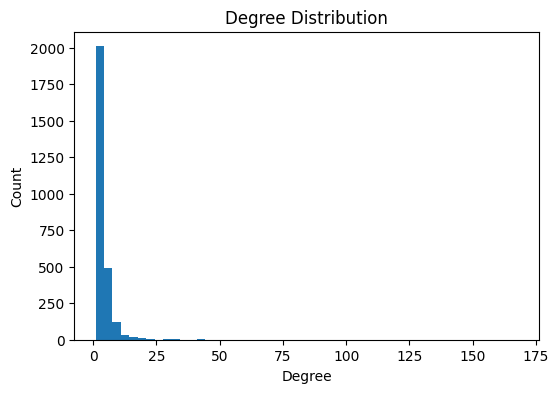

In [46]:
manager.degree_stats()

## Визуализация подграфа первых n_nodes вершин

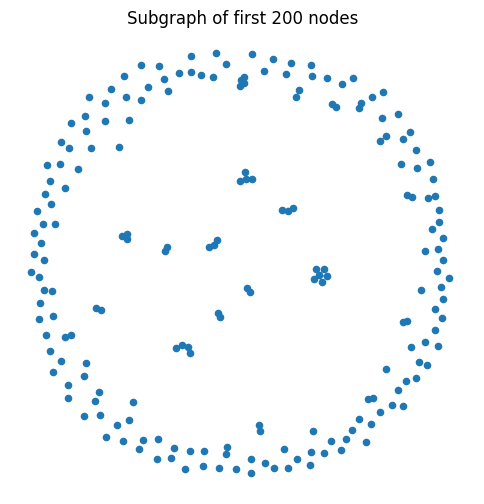

In [47]:
manager.plot_graph(n_nodes=200)

## Инициализация модели

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(hidden_channels=16).to(device)
manager.data = manager.data.to(device)

## Архитектура и число параметров

In [49]:
print("\033[92m" + "Архитектура и число параметров:" + "\033[0m")
summary(
    model,
    input_data=(manager.data.x, manager.data.edge_index),
    col_names=("input_size", "output_size", "num_params"),
    depth=6,
)

Архитектура и число параметров:


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
GCN                                      [2708, 1433]              [2708, 7]                 --
├─GCNConv: 1-1                           [2708, 1433]              [2708, 16]                16
│    └─Linear: 2-1                       [2708, 1433]              [2708, 16]                22,928
│    └─SumAggregation: 2-2               [13264, 16]               [2708, 16]                --
├─GCNConv: 1-2                           [2708, 16]                [2708, 7]                 7
│    └─Linear: 2-3                       [2708, 16]                [2708, 7]                 112
│    └─SumAggregation: 2-4               [13264, 7]                [2708, 7]                 --
Total params: 23,063
Trainable params: 23,063
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 62.39
Input size (MB): 15.69
Forward/backward pass size (MB): 0.50
Params size (MB): 0.09
Estimated Total Size (MB): 1

## Обучение модели

In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = TrainingManager(
    model, manager.data, optimizer, criterion, max_epochs=200, patience=20
)
trainer.train()

Обучение модели...
Epoch 001 | Loss: 1.9458 | Train: 0.2929 | Val: 0.3080 | Test: 0.3150
Epoch 002 | Loss: 1.9395 | Train: 0.5214 | Val: 0.4600 | Test: 0.5000
Epoch 003 | Loss: 1.9331 | Train: 0.7429 | Val: 0.5320 | Test: 0.5290
Epoch 004 | Loss: 1.9241 | Train: 0.7071 | Val: 0.4600 | Test: 0.4690
Epoch 005 | Loss: 1.9162 | Train: 0.8000 | Val: 0.5100 | Test: 0.5330
Epoch 006 | Loss: 1.9038 | Train: 0.8786 | Val: 0.5780 | Test: 0.6220
Epoch 007 | Loss: 1.8978 | Train: 0.9143 | Val: 0.7100 | Test: 0.7380
Epoch 008 | Loss: 1.8869 | Train: 0.9429 | Val: 0.7340 | Test: 0.7720
Epoch 009 | Loss: 1.8724 | Train: 0.9214 | Val: 0.7400 | Test: 0.7570
Epoch 010 | Loss: 1.8640 | Train: 0.9214 | Val: 0.7340 | Test: 0.7430
Epoch 011 | Loss: 1.8487 | Train: 0.9214 | Val: 0.7340 | Test: 0.7410
Epoch 012 | Loss: 1.8442 | Train: 0.9214 | Val: 0.7300 | Test: 0.7400
Epoch 013 | Loss: 1.8257 | Train: 0.9143 | Val: 0.7260 | Test: 0.7450
Epoch 014 | Loss: 1.8079 | Train: 0.9357 | Val: 0.7280 | Test: 0.7570
E

## Графики ошибки и точности от числа эпох

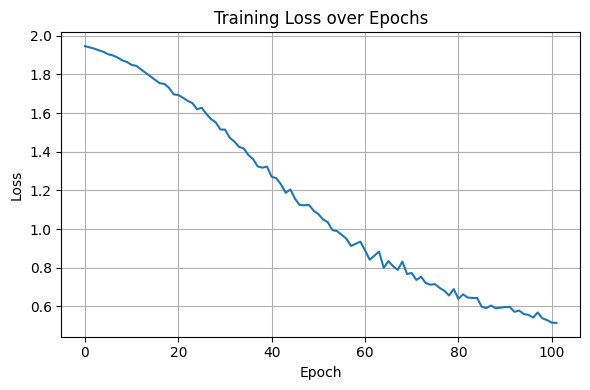

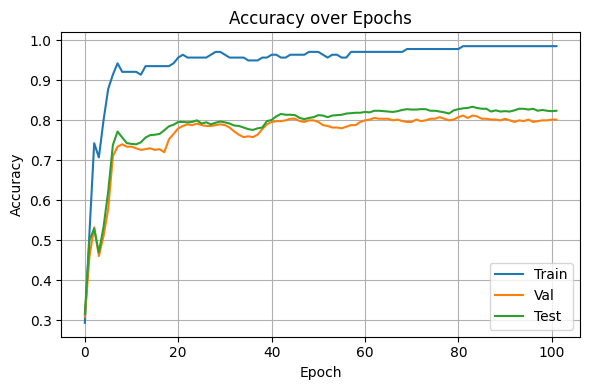

In [51]:
trainer.plot_loss()
trainer.plot_accuracy()

## Финальная точность модели

In [52]:
final_test_acc = trainer.test_accs[-1]
print("\033[92m" + f"Final Test Accuracy: {final_test_acc:.4f}" + "\033[0m")

Final Test Accuracy: 0.8240
